In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

In [31]:
df = pd.read_csv('data/series.csv')

In [32]:
df

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61
...,...,...,...
2681,CATEG-1,2021-02-18,78
2682,CATEG-2,2020-12-05,8
2683,CATEG-2,2020-02-05,3
2684,CATEG-2,2020-06-05,106


/usr/local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


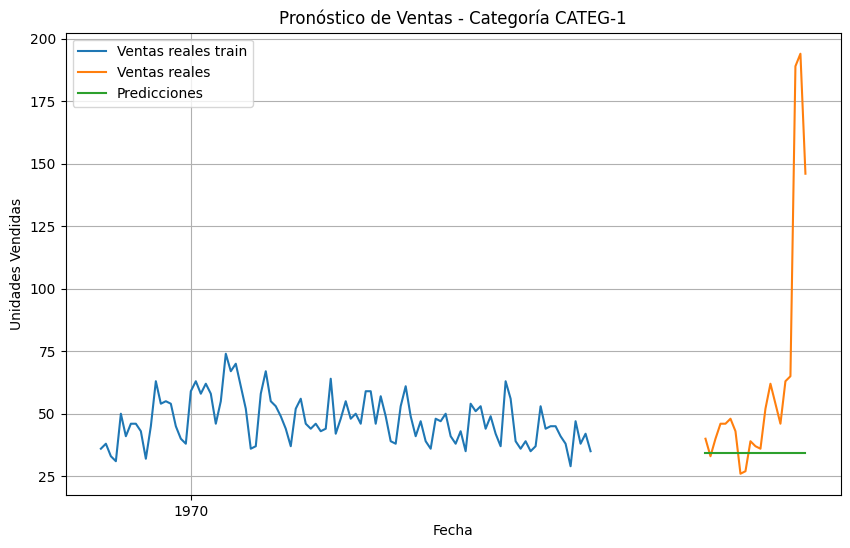

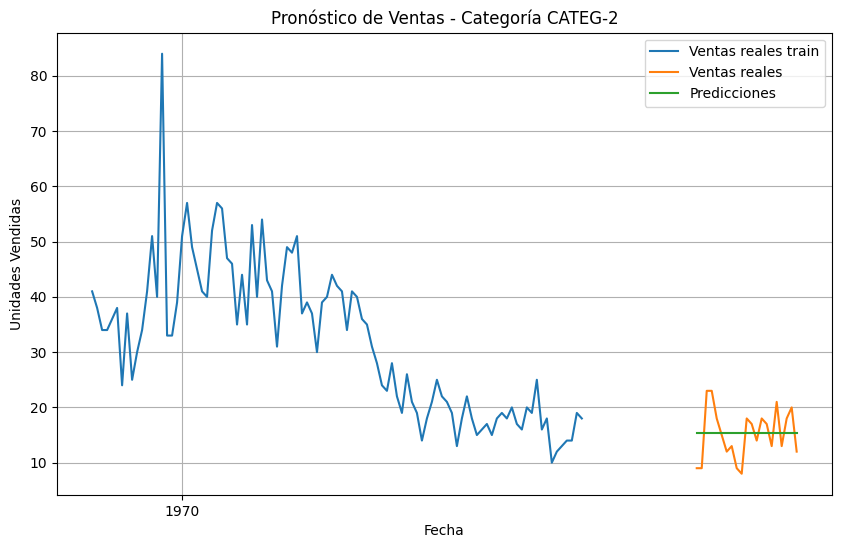

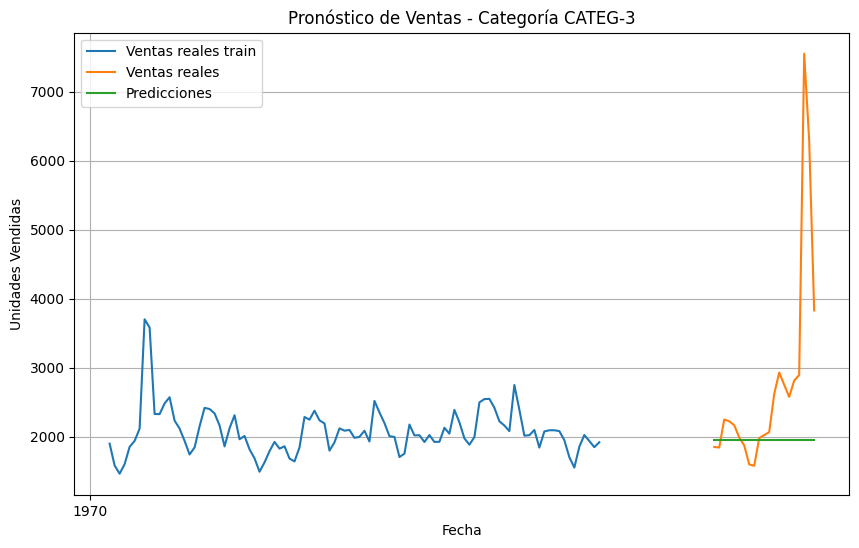

In [65]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(by='DATE')
forecast_models = {}


for categoria, datos_categoria in df.groupby('CATEGORY'):
    data = datos_categoria[['DATE', 'UNITS_SOLD']]
    data = data.rename(columns={'DATE': 'ds', 'UNITS_SOLD': 'y'})
    data['ds'] = (data['ds'] - data['ds'].min()).dt.days

    # Dividir los datos en entrenamiento, testing y validación
    train, test = train_test_split(data, test_size=21, shuffle=False)
    train, val = train_test_split(train, test_size=21, shuffle=False)

    # Entrenar el modelo 
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train[['ds']], train['y'])

    # Realizar la predicción
    forecast = model.predict(np.arange(test['ds'].min(), test['ds'].max()+1).reshape(-1, 1))
    forecast_models[categoria] = {
        'model': model,
        'forecast': forecast,
        'test_actual': test['y'],
        'test_dates': test['ds'],
        'train_dates': train['ds'][-100:-1],
        'train_values': train['y'][-100:-1]
    }

# Generar la gráfica para cada categoría
for categoria, datos in forecast_models.items():
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(datos['train_dates']), datos['train_values'], label='Ventas reales train')
    plt.plot(pd.to_datetime(datos['test_dates']), datos['test_actual'], label='Ventas reales')
    plt.plot(pd.to_datetime(datos['test_dates']), datos['forecast'], label='Predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Vendidas')
    plt.title(f'Pronóstico de Ventas - Categoría {categoria}')
    plt.legend()
    plt.grid()
    plt.show()

In [66]:
# Evaluar el rendimiento del forecast utilizando el MAE (Mean Absolute Error)
mae_total = 0
for categoria, datos in forecast_models.items():
    mae = mean_absolute_error(datos['test_actual'], datos['forecast'])
    print(f"MAE para {categoria}: {mae:.2f}")
    mae_total += mae

mae_promedio = mae_total / len(forecast_models)
print(f"MAE promedio para todas las categorías: {mae_promedio:.2f}")

MAE para CATEG-1: 30.70
MAE para CATEG-2: 3.88
MAE para CATEG-3: 891.45
MAE promedio para todas las categorías: 308.67
